## Introduction

In this report, we will be using data collected from city-data.com and applying machine learning techniques to determine the most optimal areas to invest in residential real estate. To start, we will import the dataset, remove columns that likely do not have a correlation to housing prices. Then, we will remove all rows from the dataset that contain one or more NaN values.

In [1]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import sklearn
import numpy as np
from numpy import array
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from keras import models
from keras import layers

In [2]:
# Import output.csv as df

geo_df = pd.read_csv('output.csv')

In [3]:
# Calculate population increase from 2010 to 2017

for index, row in geo_df.iterrows():
    
    if (geo_df.at[index, 'count_pop_2017'] != 0 and geo_df.at[index, 'count_pop_2010'] != 0):
        geo_df.at[index, 'pop_change_2010_2017'] = ((geo_df.at[index, 'count_pop_2017'] - geo_df.at[index, 'count_pop_2010']) / geo_df.at[index, 'count_pop_2010']) * 100
    

In [4]:
# Filter out columns that will not be used for analysis

columns = array(geo_df.columns)

remove = ['state', 'state_abbr', 'county', 'lat', 'long', 'count_pop_2017','count_pop_2010',
          'count_pop_2000', 'count_houses_condos', 'count_renter_occupied_apts',
          'land_area_sq_mi', 'water_area_sq_mi', 'percent_never_married', 'percent_now_married',
          'percent_separated', 'percent_widowed', 'percent_divorced', 'count_white',
          'count_hispanic_or_latino', 'count_asian', 'count_two_or_more_races', 'count_black',
          'count_american_indian', 'count_native_hawaiian_and_pacific_islander',
          'count_some_other_race', 'avg_household_size', 'percent_family_households',
          'percent_households_unmarried_partners',
          'median_number_rooms_apartments', 'percent_speak_english', 'percent_speak_spanish',
          'percent_foreign_born', 'percent_pop_same_house_5_years', 'percent_pop_same_house_1_year',
          'lower_quartile_house_condo_value', 'upper_quartile_house_condo_value', 'mean_price_detached_house',
          'mean_price_townhouse', 'mean_price_2_unit_structure', 'mean_price_3_to_4_unit_structure', 
          'mean_price_5_or_more_unit_structure', 'mean_price_mobile_homes']

for each in remove:
    columns = np.delete(columns, np.argwhere(columns==each))

sample_set = geo_df[columns]

sample_set.shape

(32759, 22)

In [5]:
# Remove rows that have N/A values for one or more attributes

for each in sample_set.columns:
    
    sample_set = sample_set[sample_set[each].notna()]
    
sample_set.shape

(20564, 22)

## Simple Linear Regression

Let's apply a simple linear regression model to each attribute as it relates to median house / condo value. We will generate mean absolute error, residual sum of squares (MSE), and an R2-score for each attribute

In [9]:
# Split the sample_set dataset into train / test sets 

msk = np.random.rand(len(sample_set)) <0.8
train = sample_set[msk]
test = sample_set[~msk]

In [15]:
train_y = np.asanyarray(train[['median_house_condo_value']])
test_y = np.asanyarray(test[['median_house_condo_value']])

output_cols = ['Attribute', 'MAE', 'MSE', 'R2']
output_df = pd.DataFrame(columns=output_cols)

for each in train.columns:
    # Fit the training set
    regr = linear_model.LinearRegression()
    train_x = np.asanyarray(train[[each]])
    regr.fit(train_x, train_y)
    
    # Evaluate the model
    test_x = np.asanyarray(test[[each]])
    test_y_hat = regr.predict(test_x)
    
    mae = np.mean(np.absolute(test_y_hat - test_y))
    mse = np.mean((test_y_hat - test_y) **2)
    r2 = r2_score(test_y, test_y_hat)
    
    temp_dict = {
        'Attribute': each,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }
    
    output_df = output_df.append(temp_dict, ignore_index=True)
    
output_df.sort_values(by=['R2'])

,Attribute,MAE,MSE,R2
11,median_resident_age,1.110927e+05,3.131049e+10,-0.000038
0,zip_code,1.121700e+05,3.124158e+10,0.002163
4,percent_property_taxes,1.120548e+05,3.107597e+10,0.007452
18,percent_residents_working_in_county,1.106120e+05,3.099157e+10,0.010148
21,pop_change_2010_2017,1.077292e+05,3.042892e+10,0.028119
1,percent_renters,1.089152e+05,3.028208e+10,0.032809
8,unemployment_rate,1.086607e+05,3.024700e+10,0.033929
9,mean_travel_time_to_work,1.079455e+05,3.023081e+10,0.034446
15,median_number_rooms_houses_and_condos,1.055964e+05,2.997142e+10,0.042731
20,percent_units_lacking_kitchen_facilities,1.032421e+05,2.820788e+10,0.099057


## Polynomial Regression

Let's apply a polynomial regression model to each attribute as it relates to median house / condo value. We will generate mean absolute error, residual sum of squares (MSE), and an R2-score for each attribute

In [14]:
train_y = np.asanyarray(train[['median_house_condo_value']])
test_y = np.asanyarray(test[['median_house_condo_value']])

output_cols = ['Attribute', 'MAE', 'MSE', 'R2']
output_df = pd.DataFrame(columns=output_cols)

for each in train.columns:
    # Transform the x training set
    train_x = np.asanyarray(train[[each]])
    test_x = np.asanyarray(test[[each]])
    
    poly = PolynomialFeatures(degree=4)
    train_x_poly = poly.fit_transform(train_x)
    
    # Use LinearRegression() to solve
    clf = linear_model.LinearRegression()
    clf.fit(train_x_poly, train_y)
    
    # Evaluate the model
    test_x_poly = poly.fit_transform(test_x)
    test_y_hat = clf.predict(test_x_poly)
    
    mae = np.mean(np.absolute(test_y_hat - test_y))
    mse = np.mean((test_y_hat - test_y) **2)
    r2 = r2_score(test_y, test_y_hat)
    
    temp_dict = {
        'Attribute': each,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }
    
    output_df = output_df.append(temp_dict, ignore_index=True)
    
output_df.sort_values(by=['R2'])

,Attribute,MAE,MSE,R2
4,percent_property_taxes,119748.892455,2.960944e+11,-8.457076
11,median_resident_age,110900.960716,3.126846e+10,0.001304
18,percent_residents_working_in_county,108985.238689,3.028726e+10,0.032643
21,pop_change_2010_2017,107290.988806,3.015679e+10,0.036810
9,mean_travel_time_to_work,107857.378728,3.012670e+10,0.037771
8,unemployment_rate,108161.160317,2.995289e+10,0.043323
1,percent_renters,106225.165868,2.970026e+10,0.051392
15,median_number_rooms_houses_and_condos,97495.946108,2.692280e+10,0.140102
14,percent_residents_income_below_poverty_level,97306.361653,2.663302e+10,0.149357
20,percent_units_lacking_kitchen_facilities,96459.327607,2.658053e+10,0.151034


## Multiple Linear Regression

Let's apply a multiple linear regression model to the top five attributes that have a high correlation (*median_monthly_owner_cost_with_mortgage, median_gross_rent, cost_of_living_index, percent_bachelors_degree, median_household_income_2017*) with the median house / condo value attribute. We will generate mean absolute error, residual sum of squares (MSE), R2-score and explained variance for each attribute . 

In [23]:
# Fit the model
regr = linear_model.LinearRegression()

x_train = np.asanyarray(train[['median_monthly_owner_cost_with_mortgage', 'median_gross_rent', 'cost_of_living_index', 
                         'percent_bachelors_degree', 'median_household_income_2017']])
y_train = np.asanyarray(train[['median_house_condo_value']])

regr.fit(x_train, y_train)

# Evaluate the model
x_test = np.asanyarray(test[['median_monthly_owner_cost_with_mortgage', 'median_gross_rent', 'cost_of_living_index', 
                         'percent_bachelors_degree', 'median_household_income_2017']])
y_test = np.asanyarray(test[['median_house_condo_value']])

y_hat = regr.predict(x_test)

# Publish results
mae = np.mean(np.absolute(y_hat - test_y))
mse = np.mean((y_hat - test_y) **2)
r2 = r2_score(test_y, y_hat)
ev = regr.score(x_test, y_test)

print("Mean Absolute Error: %.2f" % mae)
print("Mean Squared Error: %.2f" % mse)
print("R2: %.2f" % r2)
print("Explained Variance: %.2f" % ev)


Mean Absolute Error: 44614.96
Mean Squared Error: 5925597069.23
R2: 0.81
Explained Variance: 0.81


# K-Means Clustering 
Let's apply k-means clustering to our sample_set dataset to see if we can understand what groupings might exist as well as the characteristics that define these groupings

In [19]:
kclusters = 5

sample_set_clustering = sample_set.drop('zip_code', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sample_set_clustering)

sample_set.insert(0, 'Cluster Labels', kmeans.labels_)

sample_set.head(10)

,Cluster Labels,zip_code,percent_renters,cost_of_living_index,population_density_ppl_sq_mi,percent_property_taxes,percent_high_school_diploma,percent_bachelors_degree,percent_graduate_degree,unemployment_rate,...,median_household_income_2017,median_monthly_owner_cost_with_mortgage,percent_residents_income_below_poverty_level,median_number_rooms_houses_and_condos,median_gross_rent,median_house_condo_value,percent_residents_working_in_county,percent_units_lacking_plumbing,percent_units_lacking_kitchen_facilities,pop_change_2010_2017
0,0,59648,26.0,89.0,0.803,0.5,98.6,22.9,7.2,1.3,...,58869.0,1279.0,12.5,5.6,706.0,258871.0,92.6,13.5,13.7,-15.590551
1,3,59701,34.0,85.0,75.000,1.0,91.7,26.6,8.5,4.8,...,41511.0,1006.0,17.9,6.2,625.0,146978.0,91.9,1.6,4.7,2.374272
3,0,59710,34.0,90.6,0.426,0.5,87.0,25.9,0.0,2.3,...,48403.0,973.0,7.9,6.9,773.0,264269.0,86.8,16.7,16.0,-10.139860
4,3,59711,29.0,82.7,15.000,1.1,90.4,18.5,6.5,2.4,...,43761.0,884.0,17.1,5.8,531.0,133146.0,72.8,6.0,9.6,1.567223
6,0,59714,28.0,89.4,45.000,0.8,95.7,34.9,8.8,2.6,...,69102.0,1431.0,8.7,6.6,930.0,271128.0,96.1,0.6,1.1,9.113409
7,2,59715,48.0,98.6,78.000,0.7,99.7,62.5,25.7,4.9,...,56147.0,1880.0,17.0,7.2,880.0,447682.0,94.7,0.6,1.1,13.995628
9,2,59718,37.0,95.1,140.000,0.8,99.5,53.5,18.7,2.8,...,63398.0,1693.0,10.7,6.1,1153.0,332079.0,94.8,0.4,0.4,21.851135
12,3,59722,32.0,83.7,16.000,1.0,89.5,18.6,7.5,0.6,...,46060.0,979.0,14.2,6.2,577.0,149003.0,72.7,4.4,3.0,0.259471
16,0,59728,12.0,88.0,2.000,0.5,88.5,23.2,4.1,2.1,...,58432.0,1115.0,7.4,6.2,632.0,230307.0,38.8,17.0,15.5,6.997085
17,2,59729,26.0,92.5,4.000,0.4,93.4,35.4,11.5,4.1,...,52764.0,1410.0,5.3,6.3,805.0,361092.0,90.9,3.4,4.1,7.940215


In [34]:
# Create a table that shows the mean value for each attribute for each cluster

#output_cols = ['Attribute', '0', '1', '2', '3', '4']
output_df = pd.DataFrame()

for each in sample_set.columns:
    temp_dict = {}
    
    for cluster in range(0, kclusters):
        cur_mean = round(sample_set[sample_set['Cluster Labels']==cluster][each].mean(),2)
        
        temp_dict[cluster] = cur_mean
        
    temp_dict['Attribute'] = each
    
    output_df = output_df.append(temp_dict, ignore_index=True)
    
cols = output_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
output_df = output_df[cols]

output_df = output_df[output_df.Attribute != 'zip_code']
output_df = output_df[output_df.Attribute != 'Cluster Labels']

output_df

,Attribute,0,1,2,3,4
2,percent_renters,28.28,41.55,33.63,28.01,41.35
3,cost_of_living_index,94.12,135.49,117.11,83.74,150.21
4,population_density_ppl_sq_mi,1408.16,10336.52,4975.02,610.00,12362.16
5,percent_property_taxes,1.21,0.76,1.13,1.12,0.58
6,percent_high_school_diploma,90.17,93.55,91.28,84.23,97.84
7,percent_bachelors_degree,29.30,56.66,43.46,16.36,71.56
8,percent_graduate_degree,10.74,25.21,17.77,5.44,34.18
9,unemployment_rate,4.75,4.24,4.66,6.04,3.82
10,mean_travel_time_to_work,26.77,29.85,29.86,25.72,28.98
11,residents_per_sex_offender,1383.52,4559.74,3065.01,575.92,6013.02


# Regression Using Neural Networks

We will now use Keras, an open-source library that provides a Python interface for neural networks, to predict housing prices for zip codes based on a select number of attributes. By comparing the predicted average house / condo value for a zip code with the actual average house / condo value, we might be able to find specific zip codes where pricing is currently undervalued.

Let's start by taking a subset of sample_data - we will only include the top 10 features that had the highest correlation with median_house_condo_value after performing simple linear regression.

In [43]:
# Get top 10 features

top_ten_features = ['median_monthly_owner_cost_with_mortgage', 'median_gross_rent', 'cost_of_living_index', 
                         'percent_bachelors_degree', 'median_household_income_2017', 'percent_graduate_degree',
                   'residents_per_sex_offender', 'percent_high_school_diploma', 
                    'percent_residents_income_below_poverty_level', 'population_density_ppl_sq_mi']


# Split the sample_set dataset into train / test sets 

msk = np.random.rand(len(sample_set)) <0.8
train = sample_set[msk]
test = sample_set[~msk]

# Create training and testing sets

x_train = np.asanyarray(train[top_ten_features])
y_train = np.asanyarray(train[['median_house_condo_value']])

x_test = np.asanyarray(test[top_ten_features])
y_test = np.asanyarray(test[['median_house_condo_value']])

# Normalize the data
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_test -= mean
x_test /= std
# NOTE: Quantities used for normalizing the test data are computed using training data.

Now, let's create a function that will built the machine learning model. For this exercise, we will use three hidden layers, each with 64 units. A couple notes: 

- There is no activtion function at the end of the function, allowing the network to predict values in any range. 
- The network is compiled with the mse (mean squared error) loss function 
- The model is monitored using the mean absolute error (MAE) metric

In [45]:
def build_model():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])
    
    return model

In [46]:
# Segment training data into validation data + partial training data

x_val = x_train[:1500]
partial_x_train = x_train[1500:]

y_val = y_train[:1500]
partial_y_train = y_train[1500:]

In [47]:
# Build and fit the model

num_epochs = 100

model = build_model()
history = model.fit(partial_x_train, partial_y_train, validation_data=(x_val, y_val), 
                    epochs=num_epochs, batch_size=512, verbose=0)

mae_history = history.history['val_mae']

Let's plot the MAE vs. Epochs to see which number of epochs yields the lowest MAE.

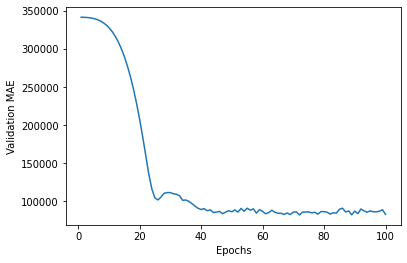

In [48]:
# Plot MAE vs. Epochs from mae_history

plt.plot(range(1, len(mae_history) + 1), mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

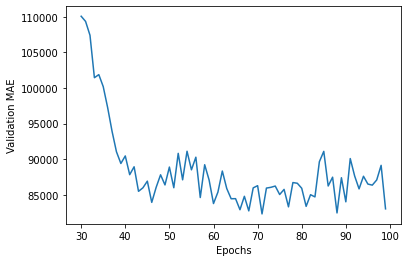

In [49]:
# Zoom in to determine which epoch number yields the lowest MAE

chopped = 30
chopped_mae_history = mae_history[chopped:]

plt.plot(range(chopped, len(chopped_mae_history) + chopped), chopped_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

The lowest MAE appears to occur around 42 epochs. Let's test our model at 42 epochs accordingly and determine the resulting MAE.

In [50]:
num_epochs = 42

model = build_model()
model.fit(partial_x_train, partial_y_train, epochs=num_epochs, batch_size=512, verbose=0)
val_mse, val_mae = model.evaluate(x_test, y_test, verbose=0)

val_mae

51565.77734375

The resulting MAE is currently __$51,565__. The next step will be to try different methods (such as incorporating other features, changing the number of hidden layers, changing the number of units, updating the batch size, etc.) to attempt to bring down the MAE even further. Once brought down to an acceptable level, we can compare the machine learning's house/ condo value predictions on test data with the actual house / condo values to determine zip codes that might currently have undervalued residential real estate.